# Train Log 20181102

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

sys.path.append( os.path.abspath('../../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *
import model_opt5 as MODEL

In [2]:
""" Path """

data_train_path_list = []
data_test_path_list = []
data_vali_path_list = []

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_20181031_ndb_aug_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_20181031_ndb_aug_v2_20181020/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_500_20181031_ndb_aug_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_500_20181031_ndb_aug_v2_20181020/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_400_20181031_ndb_aug_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_400_20181031_ndb_aug_v2_20181020/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_300_20181031_ndb_aug_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_300_20181031_ndb_aug_v2_20181020/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_200_20181031_ndb_aug_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_200_20181031_ndb_aug_v2_20181020/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_100_20181031_ndb_aug_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_100_20181031_ndb_aug_v2_20181020/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

log_path = os.path.abspath('./train_log_20181101.txt')

model_save_path = os.path.abspath('./model')
if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)

""" Parameters """
GPU_INDEX = 0
NUM_POINT = 256
NUM_CLASSES = 5

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(200000)
BN_DECAY_CLIP = 0.99
DECAY_STEP = BN_DECAY_DECAY_STEP
DECAY_RATE = BN_DECAY_DECAY_RATE

BATCH_SIZE = 250

MOMENTUM = 0.9

BASE_LEARNING_RATE = 0.001

OPTIMIZER = 'adam'

MAX_EPOCH = 10

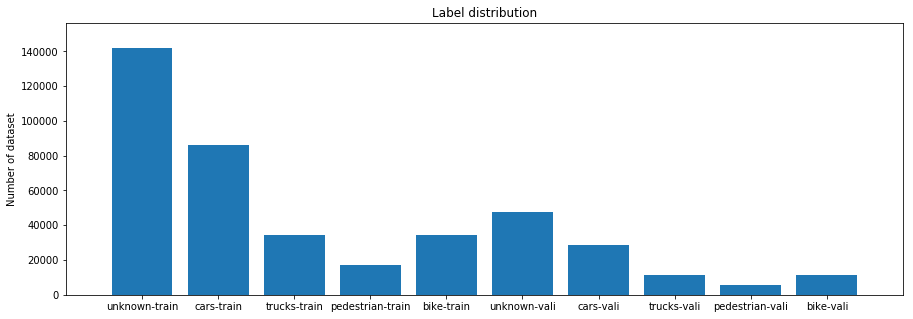

In [3]:
""" Load dataset"""

data = []
label = []

data_train, label_train = load_h5(data_train_path_list[0])
data_vali, label_vali = load_h5(data_vali_path_list[0])
    
for i in range( 1, len(data_train_path_list) ):

    d_train, l_train = load_h5(data_train_path_list[i])
    d_vali, l_vali = load_h5(data_vali_path_list[i])
    
    data_train = np.concatenate( (data_train, d_train), axis = 0 )
    data_vali = np.concatenate( (data_vali, d_vali), axis = 0 )
    
    label_train = np.concatenate( (label_train, l_train), axis = 0 )
    label_vali = np.concatenate( (label_vali, l_vali), axis = 0 )
    

data.append(data_train)
data.append(data_vali)

label.append(label_train)
label.append(label_vali)

""" Data statistics """

label_list = [0,1,2,3,4]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train', 'trucks-train', 'pedestrian-train', 'bike-train',
        'unknown-vali', 'cars-vali', 'trucks-vali', 'pedestrian-vali', 'bike-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
""" log file """
LOG_FOUT = open(log_path, 'w')

def log_string(out_str):
    out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)
    
    
def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      BN_INIT_DECAY,
                      batch * BATCH_SIZE,
                      BN_DECAY_DECAY_STEP,
                      BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

""" load traing model """
with tf.Graph().as_default():
    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())
        print(is_training_pl)

        # Note the global_step=batch parameter to minimize. 
        # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
        batch = tf.Variable(0)
        bn_decay = get_bn_decay(batch)
        tf.summary.scalar('bn_decay', bn_decay)

        # Get model and loss 
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
        loss = MODEL.get_loss(pred, labels_pl, end_points)
        tf.summary.scalar('loss', loss)

        correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
        accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
        tf.summary.scalar('accuracy', accuracy)

        # Get training operator
        learning_rate = get_learning_rate(batch)
        tf.summary.scalar('learning_rate', learning_rate)
        if OPTIMIZER == 'momentum':
            optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
        elif OPTIMIZER == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss, global_step=batch)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess = tf.Session(config=config)

    # Add summary writers
    #merged = tf.merge_all_summaries()
    merged = tf.summary.merge_all()

    train_writer_path = os.path.abspath('./train')
    if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
    os.mkdir(train_writer_path)
        
    test_writer_path = os.path.abspath('./test')
    if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
    os.mkdir(test_writer_path)
    
    
    train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
    test_writer = tf.summary.FileWriter(test_writer_path)
    
    
    # Init variables
    init = tf.global_variables_initializer()
    # To fix the bug introduced in TF 0.12.1 as in
    # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
    #sess.run(init)
    sess.run(init, {is_training_pl: True})

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss,
           'train_op': train_op,
           'merged': merged,
           'step': batch}
    
    data_train = data[0]
    label_train = label[0]
        
    data_vali = data[1]
    label_vali = label[1]
            
    for epoch in range(MAX_EPOCH):
        
        ## Training
        log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = True
        
        # Shuffle train files
        train_file_idxs = np.arange(0, data_train.shape[0])
        np.random.shuffle(train_file_idxs)
        
        current_data = data_train[train_file_idxs] 
        current_label = label_train[train_file_idxs]
              
        ## Evaluation metric
        total_correct = 0
        total_seen = 0
        loss_sum = 0
        
        total_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
            
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE           

            # Augment batched point clouds by rotation and jittering
            rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
            jittered_data = provider.jitter_point_cloud(rotated_data)
            
            feed_dict = {ops['pointclouds_pl']: jittered_data,
                         ops['labels_pl']: current_label[start_idx:end_idx],
                         ops['is_training_pl']: is_training,}
            
            summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            train_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss_val
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


        ## Evaluation using validation set    
        log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = False
        total_correct = 0
        total_seen = 0
        total_seen_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
        
        # Shuffle validation files
        file_idxs = np.arange(0, data_vali.shape[0])
        np.random.shuffle(file_idxs)
        
        current_data = data_vali[file_idxs]
        current_label = label_vali[file_idxs]
        
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE

            feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                         ops['labels_pl']: current_label[start_idx:end_idx],
                         ops['is_training_pl']: is_training}
            summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            # test_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] vali mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    
            
        # Save the variables to disk.
        if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            log_string("Model saved in file: %s" % save_path)
                

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-11-02 08:53:19.504458   Train one epoch   1 /  10


100%|██████████| 1259/1259 [04:56<00:00,  4.24it/s]

2018-11-02 08:58:17.684060  [Epoch 0] mean loss: 0.002170
2018-11-02 08:58:17.684453  [Epoch 0] accuracy: 0.823574
2018-11-02 08:58:17.685106  [Epoch 0] avg class acc: 0.912352
2018-11-02 08:58:17.685289  [Epoch 0] indivisual [0] class recall: 0.900901
2018-11-02 08:58:17.685435  [Epoch 0] indivisual [0] class precision: 0.909091
2018-11-02 08:58:17.685689  [Epoch 0] indivisual [1] class recall: 0.930556
2018-11-02 08:58:17.685808  [Epoch 0] indivisual [1] class precision: 0.957143
2018-11-02 08:58:17.686638  [Epoch 0] indivisual [2] class recall: 0.863636
2018-11-02 08:58:17.686727  [Epoch 0] indivisual [2] class precision: 0.760000
2018-11-02 08:58:17.687188  [Epoch 0] indivisual [3] class recall: 0.933333
2018-11-02 08:58:17.687378  [Epoch 0] indivisual [3] class precision: 0.875000
2018-11-02 08:58:17.687497  [Epoch 0] indivisual [4] class recall: 0.933333
2018-11-02 08:58:17.687697  [Epoch 0] indivisual [4] class precision: 0.965517
2018-11-02 08:58:17.688268   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.31it/s]

2018-11-02 08:58:38.791235  [Epoch 0] vali mean loss: 0.006519
2018-11-02 08:58:38.792311  [Epoch 0] vali accuracy: 0.914033
2018-11-02 08:58:38.792811  [Epoch 0] vali avg class acc: 0.200000
2018-11-02 08:58:38.793312  [Epoch 0] vali indivisual [0] class recall: 0.974576
2018-11-02 08:58:38.793435  [Epoch 0] vali indivisual [0] class precision: 0.912698
2018-11-02 08:58:38.793898  [Epoch 0] vali indivisual [1] class recall: 0.944444
2018-11-02 08:58:38.794047  [Epoch 0] vali indivisual [1] class precision: 1.000000
2018-11-02 08:58:38.794215  [Epoch 0] vali indivisual [2] class recall: 0.833333
2018-11-02 08:58:38.794454  [Epoch 0] vali indivisual [2] class precision: 0.892857
2018-11-02 08:58:38.794703  [Epoch 0] vali indivisual [3] class recall: 0.750000
2018-11-02 08:58:38.798040  [Epoch 0] vali indivisual [3] class precision: 1.000000
2018-11-02 08:58:38.798535  [Epoch 0] vali indivisual [4] class recall: 1.000000
2018-11-02 08:58:38.798975  [Epoch 0] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:55<00:00,  4.26it/s]

2018-11-02 09:03:35.688859  [Epoch 1] mean loss: 0.000797
2018-11-02 09:03:35.689631  [Epoch 1] accuracy: 0.935778
2018-11-02 09:03:35.690030  [Epoch 1] avg class acc: 0.960058
2018-11-02 09:03:35.690597  [Epoch 1] indivisual [0] class recall: 0.972222
2018-11-02 09:03:35.691055  [Epoch 1] indivisual [0] class precision: 0.945946
2018-11-02 09:03:35.691335  [Epoch 1] indivisual [1] class recall: 1.000000
2018-11-02 09:03:35.691438  [Epoch 1] indivisual [1] class precision: 0.966667
2018-11-02 09:03:35.691700  [Epoch 1] indivisual [2] class recall: 0.894737
2018-11-02 09:03:35.691828  [Epoch 1] indivisual [2] class precision: 0.971429
2018-11-02 09:03:35.691999  [Epoch 1] indivisual [3] class recall: 1.000000
2018-11-02 09:03:35.692144  [Epoch 1] indivisual [3] class precision: 1.000000
2018-11-02 09:03:35.692404  [Epoch 1] indivisual [4] class recall: 0.933333
2018-11-02 09:03:35.692623  [Epoch 1] indivisual [4] class precision: 1.000000
2018-11-02 09:03:35.693289   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.52it/s]


2018-11-02 09:03:56.615837  [Epoch 1] vali mean loss: 0.002396
2018-11-02 09:03:56.616227  [Epoch 1] vali accuracy: 0.976878
2018-11-02 09:03:56.617186  [Epoch 1] vali avg class acc: 0.200000
2018-11-02 09:03:56.617375  [Epoch 1] vali indivisual [0] class recall: 0.959350
2018-11-02 09:03:56.617569  [Epoch 1] vali indivisual [0] class precision: 0.975207
2018-11-02 09:03:56.617823  [Epoch 1] vali indivisual [1] class recall: 1.000000
2018-11-02 09:03:56.618286  [Epoch 1] vali indivisual [1] class precision: 0.983333
2018-11-02 09:03:56.618453  [Epoch 1] vali indivisual [2] class recall: 0.969697
2018-11-02 09:03:56.618693  [Epoch 1] vali indivisual [2] class precision: 0.969697
2018-11-02 09:03:56.619109  [Epoch 1] vali indivisual [3] class recall: 0.909091
2018-11-02 09:03:56.619816  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-11-02 09:03:56.620098  [Epoch 1] vali indivisual [4] class recall: 0.958333
2018-11-02 09:03:56.620219  [Epoch 1] vali indivisual [4] class pre

100%|██████████| 1259/1259 [05:00<00:00,  4.19it/s]

2018-11-02 09:08:58.507772  [Epoch 2] mean loss: 0.000479
2018-11-02 09:08:58.508494  [Epoch 2] accuracy: 0.963114
2018-11-02 09:08:58.509408  [Epoch 2] avg class acc: 0.971515
2018-11-02 09:08:58.509615  [Epoch 2] indivisual [0] class recall: 0.924242
2018-11-02 09:08:58.509803  [Epoch 2] indivisual [0] class precision: 0.983871
2018-11-02 09:08:58.510017  [Epoch 2] indivisual [1] class recall: 1.000000
2018-11-02 09:08:58.510166  [Epoch 2] indivisual [1] class precision: 1.000000
2018-11-02 09:08:58.510391  [Epoch 2] indivisual [2] class recall: 1.000000
2018-11-02 09:08:58.510513  [Epoch 2] indivisual [2] class precision: 0.766667
2018-11-02 09:08:58.510629  [Epoch 2] indivisual [3] class recall: 1.000000
2018-11-02 09:08:58.511627  [Epoch 2] indivisual [3] class precision: 0.923077
2018-11-02 09:08:58.511902  [Epoch 2] indivisual [4] class recall: 0.933333
2018-11-02 09:08:58.512103  [Epoch 2] indivisual [4] class precision: 0.933333
2018-11-02 09:08:58.512308   Evaluation one (val


100%|██████████| 419/419 [00:21<00:00, 19.89it/s]

2018-11-02 09:09:20.024017  [Epoch 2] vali mean loss: 0.001439
2018-11-02 09:09:20.024521  [Epoch 2] vali accuracy: 0.980229
2018-11-02 09:09:20.025192  [Epoch 2] vali avg class acc: 0.400000
2018-11-02 09:09:20.025518  [Epoch 2] vali indivisual [0] class recall: 0.981481
2018-11-02 09:09:20.025764  [Epoch 2] vali indivisual [0] class precision: 0.972477
2018-11-02 09:09:20.026104  [Epoch 2] vali indivisual [1] class recall: 0.986111
2018-11-02 09:09:20.026433  [Epoch 2] vali indivisual [1] class precision: 1.000000
2018-11-02 09:09:20.026662  [Epoch 2] vali indivisual [2] class recall: 0.923077
2018-11-02 09:09:20.026887  [Epoch 2] vali indivisual [2] class precision: 0.923077
2018-11-02 09:09:20.027172  [Epoch 2] vali indivisual [3] class recall: 1.000000
2018-11-02 09:09:20.027497  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-11-02 09:09:20.027846  [Epoch 2] vali indivisual [4] class recall: 1.000000
2018-11-02 09:09:20.027941  [Epoch 2] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:55<00:00,  4.25it/s]

2018-11-02 09:14:17.151342  [Epoch 3] mean loss: 0.000364
2018-11-02 09:14:17.152024  [Epoch 3] accuracy: 0.973061
2018-11-02 09:14:17.152386  [Epoch 3] avg class acc: 0.975758
2018-11-02 09:14:17.152973  [Epoch 3] indivisual [0] class recall: 1.000000
2018-11-02 09:14:17.153179  [Epoch 3] indivisual [0] class precision: 0.964602
2018-11-02 09:14:17.153292  [Epoch 3] indivisual [1] class recall: 1.000000
2018-11-02 09:14:17.153766  [Epoch 3] indivisual [1] class precision: 1.000000
2018-11-02 09:14:17.153902  [Epoch 3] indivisual [2] class recall: 0.878788
2018-11-02 09:14:17.154044  [Epoch 3] indivisual [2] class precision: 1.000000
2018-11-02 09:14:17.154162  [Epoch 3] indivisual [3] class recall: 1.000000
2018-11-02 09:14:17.154765  [Epoch 3] indivisual [3] class precision: 1.000000
2018-11-02 09:14:17.154877  [Epoch 3] indivisual [4] class recall: 1.000000
2018-11-02 09:14:17.155069  [Epoch 3] indivisual [4] class precision: 1.000000
2018-11-02 09:14:17.155352   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.47it/s]

2018-11-02 09:14:38.133249  [Epoch 3] vali mean loss: 0.001093
2018-11-02 09:14:38.134123  [Epoch 3] vali accuracy: 0.985890
2018-11-02 09:14:38.134712  [Epoch 3] vali avg class acc: 0.800000
2018-11-02 09:14:38.135176  [Epoch 3] vali indivisual [0] class recall: 0.966667
2018-11-02 09:14:38.135602  [Epoch 3] vali indivisual [0] class precision: 1.000000
2018-11-02 09:14:38.135717  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-11-02 09:14:38.135959  [Epoch 3] vali indivisual [1] class precision: 0.985714
2018-11-02 09:14:38.136271  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-11-02 09:14:38.136404  [Epoch 3] vali indivisual [2] class precision: 1.000000
2018-11-02 09:14:38.136626  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-11-02 09:14:38.136803  [Epoch 3] vali indivisual [3] class precision: 0.727273
2018-11-02 09:14:38.137357  [Epoch 3] vali indivisual [4] class recall: 1.000000
2018-11-02 09:14:38.137574  [Epoch 3] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:56<00:00,  4.25it/s]

2018-11-02 09:19:35.590339  [Epoch 4] mean loss: 0.000326
2018-11-02 09:19:35.591085  [Epoch 4] accuracy: 0.976264
2018-11-02 09:19:35.591782  [Epoch 4] avg class acc: 0.983304
2018-11-02 09:19:35.592016  [Epoch 4] indivisual [0] class recall: 0.960000
2018-11-02 09:19:35.592376  [Epoch 4] indivisual [0] class precision: 0.991736
2018-11-02 09:19:35.592660  [Epoch 4] indivisual [1] class recall: 1.000000
2018-11-02 09:19:35.592794  [Epoch 4] indivisual [1] class precision: 1.000000
2018-11-02 09:19:35.593260  [Epoch 4] indivisual [2] class recall: 1.000000
2018-11-02 09:19:35.593455  [Epoch 4] indivisual [2] class precision: 0.913043
2018-11-02 09:19:35.593738  [Epoch 4] indivisual [3] class recall: 1.000000
2018-11-02 09:19:35.593959  [Epoch 4] indivisual [3] class precision: 0.944444
2018-11-02 09:19:35.594220  [Epoch 4] indivisual [4] class recall: 0.956522
2018-11-02 09:19:35.594540  [Epoch 4] indivisual [4] class precision: 0.916667
2018-11-02 09:19:35.594885   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.63it/s]

2018-11-02 09:19:56.343785  [Epoch 4] vali mean loss: 0.000980
2018-11-02 09:19:56.344338  [Epoch 4] vali accuracy: 0.986807
2018-11-02 09:19:56.344973  [Epoch 4] vali avg class acc: 0.200000
2018-11-02 09:19:56.345410  [Epoch 4] vali indivisual [0] class recall: 0.983051
2018-11-02 09:19:56.345651  [Epoch 4] vali indivisual [0] class precision: 0.974790
2018-11-02 09:19:56.346186  [Epoch 4] vali indivisual [1] class recall: 1.000000
2018-11-02 09:19:56.346360  [Epoch 4] vali indivisual [1] class precision: 1.000000
2018-11-02 09:19:56.346887  [Epoch 4] vali indivisual [2] class recall: 0.966667
2018-11-02 09:19:56.347116  [Epoch 4] vali indivisual [2] class precision: 0.966667
2018-11-02 09:19:56.347247  [Epoch 4] vali indivisual [3] class recall: 0.947368
2018-11-02 09:19:56.347651  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-11-02 09:19:56.348022  [Epoch 4] vali indivisual [4] class recall: 0.954545
2018-11-02 09:19:56.348280  [Epoch 4] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:56<00:00,  4.25it/s]

2018-11-02 09:24:53.474580  [Epoch 5] mean loss: 0.000314
2018-11-02 09:24:53.475422  [Epoch 5] accuracy: 0.976972
2018-11-02 09:24:53.476065  [Epoch 5] avg class acc: 0.963567
2018-11-02 09:24:53.476394  [Epoch 5] indivisual [0] class recall: 0.935484
2018-11-02 09:24:53.476543  [Epoch 5] indivisual [0] class precision: 0.983051
2018-11-02 09:24:53.477092  [Epoch 5] indivisual [1] class recall: 1.000000
2018-11-02 09:24:53.477197  [Epoch 5] indivisual [1] class precision: 0.984375
2018-11-02 09:24:53.477286  [Epoch 5] indivisual [2] class recall: 1.000000
2018-11-02 09:24:53.477441  [Epoch 5] indivisual [2] class precision: 0.960000
2018-11-02 09:24:53.477948  [Epoch 5] indivisual [3] class recall: 0.882353
2018-11-02 09:24:53.478100  [Epoch 5] indivisual [3] class precision: 0.882353
2018-11-02 09:24:53.478330  [Epoch 5] indivisual [4] class recall: 1.000000
2018-11-02 09:24:53.478535  [Epoch 5] indivisual [4] class precision: 0.846154
2018-11-02 09:24:53.478974   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.33it/s]

2018-11-02 09:25:14.535291  [Epoch 5] vali mean loss: 0.000943
2018-11-02 09:25:14.535794  [Epoch 5] vali accuracy: 0.986988
2018-11-02 09:25:14.536386  [Epoch 5] vali avg class acc: 0.800000
2018-11-02 09:25:14.536771  [Epoch 5] vali indivisual [0] class recall: 0.990385
2018-11-02 09:25:14.537373  [Epoch 5] vali indivisual [0] class precision: 1.000000
2018-11-02 09:25:14.537761  [Epoch 5] vali indivisual [1] class recall: 1.000000
2018-11-02 09:25:14.537868  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-11-02 09:25:14.538105  [Epoch 5] vali indivisual [2] class recall: 1.000000
2018-11-02 09:25:14.538417  [Epoch 5] vali indivisual [2] class precision: 0.964286
2018-11-02 09:25:14.538549  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-11-02 09:25:14.539112  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-11-02 09:25:14.539382  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-11-02 09:25:14.539480  [Epoch 5] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:56<00:00,  4.25it/s]

2018-11-02 09:30:11.857111  [Epoch 6] mean loss: 0.000308
2018-11-02 09:30:11.857433  [Epoch 6] accuracy: 0.977503
2018-11-02 09:30:11.858128  [Epoch 6] avg class acc: 0.981885
2018-11-02 09:30:11.858319  [Epoch 6] indivisual [0] class recall: 0.972477
2018-11-02 09:30:11.858554  [Epoch 6] indivisual [0] class precision: 0.981481
2018-11-02 09:30:11.859208  [Epoch 6] indivisual [1] class recall: 1.000000
2018-11-02 09:30:11.859329  [Epoch 6] indivisual [1] class precision: 0.971014
2018-11-02 09:30:11.859483  [Epoch 6] indivisual [2] class recall: 0.965517
2018-11-02 09:30:11.859715  [Epoch 6] indivisual [2] class precision: 1.000000
2018-11-02 09:30:11.859953  [Epoch 6] indivisual [3] class recall: 1.000000
2018-11-02 09:30:11.860363  [Epoch 6] indivisual [3] class precision: 0.909091
2018-11-02 09:30:11.860620  [Epoch 6] indivisual [4] class recall: 0.971429
2018-11-02 09:30:11.860772  [Epoch 6] indivisual [4] class precision: 1.000000
2018-11-02 09:30:11.860969   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.74it/s]

2018-11-02 09:30:32.521251  [Epoch 6] vali mean loss: 0.000924
2018-11-02 09:30:32.521981  [Epoch 6] vali accuracy: 0.988124
2018-11-02 09:30:32.522344  [Epoch 6] vali avg class acc: 0.800000
2018-11-02 09:30:32.522874  [Epoch 6] vali indivisual [0] class recall: 0.980769
2018-11-02 09:30:32.523005  [Epoch 6] vali indivisual [0] class precision: 1.000000
2018-11-02 09:30:32.523337  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-11-02 09:30:32.523700  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-11-02 09:30:32.524064  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-11-02 09:30:32.524166  [Epoch 6] vali indivisual [2] class precision: 0.972222
2018-11-02 09:30:32.524260  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-11-02 09:30:32.524418  [Epoch 6] vali indivisual [3] class precision: 0.875000
2018-11-02 09:30:32.524989  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-11-02 09:30:32.525262  [Epoch 6] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:56<00:00,  4.25it/s]

2018-11-02 09:35:29.684922  [Epoch 7] mean loss: 0.000296
2018-11-02 09:35:29.685400  [Epoch 7] accuracy: 0.978434
2018-11-02 09:35:29.685794  [Epoch 7] avg class acc: 0.989770
2018-11-02 09:35:29.686000  [Epoch 7] indivisual [0] class recall: 0.983333
2018-11-02 09:35:29.686356  [Epoch 7] indivisual [0] class precision: 0.991597
2018-11-02 09:35:29.687061  [Epoch 7] indivisual [1] class recall: 1.000000
2018-11-02 09:35:29.687360  [Epoch 7] indivisual [1] class precision: 1.000000
2018-11-02 09:35:29.687572  [Epoch 7] indivisual [2] class recall: 1.000000
2018-11-02 09:35:29.687726  [Epoch 7] indivisual [2] class precision: 0.923077
2018-11-02 09:35:29.687986  [Epoch 7] indivisual [3] class recall: 1.000000
2018-11-02 09:35:29.688107  [Epoch 7] indivisual [3] class precision: 1.000000
2018-11-02 09:35:29.688792  [Epoch 7] indivisual [4] class recall: 0.965517
2018-11-02 09:35:29.689154  [Epoch 7] indivisual [4] class precision: 1.000000
2018-11-02 09:35:29.689256   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.75it/s]

2018-11-02 09:35:50.349000  [Epoch 7] vali mean loss: 0.000889
2018-11-02 09:35:50.350098  [Epoch 7] vali accuracy: 0.988124
2018-11-02 09:35:50.350466  [Epoch 7] vali avg class acc: 0.800000
2018-11-02 09:35:50.350692  [Epoch 7] vali indivisual [0] class recall: 0.974359
2018-11-02 09:35:50.351280  [Epoch 7] vali indivisual [0] class precision: 1.000000
2018-11-02 09:35:50.351684  [Epoch 7] vali indivisual [1] class recall: 1.000000
2018-11-02 09:35:50.351797  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-11-02 09:35:50.352223  [Epoch 7] vali indivisual [2] class recall: 1.000000
2018-11-02 09:35:50.352344  [Epoch 7] vali indivisual [2] class precision: 0.925926
2018-11-02 09:35:50.352542  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-11-02 09:35:50.352687  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-11-02 09:35:50.352859  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-11-02 09:35:50.353046  [Epoch 7] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:55<00:00,  4.25it/s]

2018-11-02 09:40:47.533601  [Epoch 8] mean loss: 0.000288
2018-11-02 09:40:47.534498  [Epoch 8] accuracy: 0.978993
2018-11-02 09:40:47.535319  [Epoch 8] avg class acc: 0.972834
2018-11-02 09:40:47.535583  [Epoch 8] indivisual [0] class recall: 0.981818
2018-11-02 09:40:47.535890  [Epoch 8] indivisual [0] class precision: 0.964286
2018-11-02 09:40:47.536313  [Epoch 8] indivisual [1] class recall: 1.000000
2018-11-02 09:40:47.536420  [Epoch 8] indivisual [1] class precision: 1.000000
2018-11-02 09:40:47.536511  [Epoch 8] indivisual [2] class recall: 1.000000
2018-11-02 09:40:47.536667  [Epoch 8] indivisual [2] class precision: 0.961538
2018-11-02 09:40:47.537247  [Epoch 8] indivisual [3] class recall: 1.000000
2018-11-02 09:40:47.537479  [Epoch 8] indivisual [3] class precision: 0.937500
2018-11-02 09:40:47.537649  [Epoch 8] indivisual [4] class recall: 0.882353
2018-11-02 09:40:47.537897  [Epoch 8] indivisual [4] class precision: 1.000000
2018-11-02 09:40:47.538236   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.73it/s]

2018-11-02 09:41:08.190419  [Epoch 8] vali mean loss: 0.000864
2018-11-02 09:41:08.191337  [Epoch 8] vali accuracy: 0.989604
2018-11-02 09:41:08.191769  [Epoch 8] vali avg class acc: 0.600000
2018-11-02 09:41:08.192315  [Epoch 8] vali indivisual [0] class recall: 0.980952
2018-11-02 09:41:08.192490  [Epoch 8] vali indivisual [0] class precision: 0.990385
2018-11-02 09:41:08.192750  [Epoch 8] vali indivisual [1] class recall: 1.000000
2018-11-02 09:41:08.193021  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-11-02 09:41:08.193290  [Epoch 8] vali indivisual [2] class recall: 0.960000
2018-11-02 09:41:08.193704  [Epoch 8] vali indivisual [2] class precision: 0.923077
2018-11-02 09:41:08.193803  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-11-02 09:41:08.193893  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-11-02 09:41:08.194312  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-11-02 09:41:08.194510  [Epoch 8] vali indivisual [4] class pre


100%|██████████| 1259/1259 [04:56<00:00,  4.25it/s]

2018-11-02 09:46:05.354508  [Epoch 9] mean loss: 0.000282
2018-11-02 09:46:05.355109  [Epoch 9] accuracy: 0.979609
2018-11-02 09:46:05.356040  [Epoch 9] avg class acc: 0.979644
2018-11-02 09:46:05.356191  [Epoch 9] indivisual [0] class recall: 0.966387
2018-11-02 09:46:05.356442  [Epoch 9] indivisual [0] class precision: 0.974576
2018-11-02 09:46:05.356735  [Epoch 9] indivisual [1] class recall: 0.971831
2018-11-02 09:46:05.357078  [Epoch 9] indivisual [1] class precision: 0.985714
2018-11-02 09:46:05.357345  [Epoch 9] indivisual [2] class recall: 0.960000
2018-11-02 09:46:05.357689  [Epoch 9] indivisual [2] class precision: 0.960000
2018-11-02 09:46:05.357959  [Epoch 9] indivisual [3] class recall: 1.000000
2018-11-02 09:46:05.358365  [Epoch 9] indivisual [3] class precision: 1.000000
2018-11-02 09:46:05.358466  [Epoch 9] indivisual [4] class recall: 1.000000
2018-11-02 09:46:05.358720  [Epoch 9] indivisual [4] class precision: 0.916667
2018-11-02 09:46:05.358976   Evaluation one (val


100%|██████████| 419/419 [00:20<00:00, 20.68it/s]


2018-11-02 09:46:26.141176  [Epoch 9] vali mean loss: 0.000848
2018-11-02 09:46:26.141648  [Epoch 9] vali accuracy: 0.989251
2018-11-02 09:46:26.142548  [Epoch 9] vali avg class acc: 0.800000
2018-11-02 09:46:26.142776  [Epoch 9] vali indivisual [0] class recall: 0.968000
2018-11-02 09:46:26.142952  [Epoch 9] vali indivisual [0] class precision: 1.000000
2018-11-02 09:46:26.143120  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-11-02 09:46:26.143727  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-11-02 09:46:26.144079  [Epoch 9] vali indivisual [2] class recall: 1.000000
2018-11-02 09:46:26.144449  [Epoch 9] vali indivisual [2] class precision: 0.916667
2018-11-02 09:46:26.144547  [Epoch 9] vali indivisual [3] class recall: 1.000000
2018-11-02 09:46:26.144822  [Epoch 9] vali indivisual [3] class precision: 1.000000
2018-11-02 09:46:26.145088  [Epoch 9] vali indivisual [4] class recall: 1.000000
2018-11-02 09:46:26.145503  [Epoch 9] vali indivisual [4] class pre